# EDA for JPX Tokyo Stock Exchange Prediction

## import libs

In [2]:
import pandas as pd
import numpy as np
import sklearn.model_selection as sms 
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import os
import gc
from sklearn.metrics import mean_squared_error
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _BaseKFold

/Users/dylan/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## import data

### Reduce the size of data

In [57]:
'''def reduce_mem_usage(df, verbose=True):
    
    //reduce every columns mem useage 
    //change the dtype of it 
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


for file in os.listdir('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/train_files'):
    if file.endswith('csv'):
        df = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/train_files/'+file)
        df = reduce_mem_usage(df)
        df.to_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/reduced_train_files/'+'reduced_'+file, index=False)
        print('reduce mem usage of '+file+' done')
        gc.collect()
'''


"def reduce_mem_usage(df, verbose=True):\n    \n    //reduce every columns mem useage \n    //change the dtype of it \n    \n    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']\n    start_mem = df.memory_usage().sum() / 1024**2    \n    for col in df.columns:\n        col_type = df[col].dtypes\n        if col_type in numerics:\n            c_min = df[col].min()\n            c_max = df[col].max()\n            if str(col_type)[:3] == 'int':\n                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:\n                    df[col] = df[col].astype(np.int8)\n                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:\n                    df[col] = df[col].astype(np.int16)\n                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:\n                    df[col] = df[col].astype(np.int32)\n                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:\n             

In [6]:
stock_price_data = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/reduced_train_files/reduced_stock_prices.csv')
financials_data = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/reduced_train_files/reduced_financials.csv')
options_data = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/reduced_train_files/reduced_options.csv')
secondary_data = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/reduced_train_files/reduced_secondary_stock_prices.csv')
trades_data = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/reduced_train_files/reduced_trades.csv')

/var/folders/9l/qzgwttq17ps8lhfhrtgpdkx00000gn/T/ipykernel_55377/3517953822.py:2: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  financials_data = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/reduced_train_files/reduced_financials.csv')
/var/folders/9l/qzgwttq17ps8lhfhrtgpdkx00000gn/T/ipykernel_55377/3517953822.py:3: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  options_data = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/reduced_train_files/reduced_options.csv')


Firstly, look at the stock price data

In [59]:
stock_price_data.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [60]:
stock_price_data.tail()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098
2332530,20211203_9997,2021-12-03,9997,690.0,711.0,686.0,696.0,381100,1.0,NaN,False,0.018414


In [61]:
stock_price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [62]:
stock_price_data.describe()

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,2.332531e+06,2.324923e+06,2.324923e+06,2.324923e+06,2.324923e+06,2.332531e+06,2.332531e+06,18865.000000,2.332293e+06
mean,5.894835e+03,2.594511e+03,2.626540e+03,2.561227e+03,2.594023e+03,6.919366e+05,1.000508e+00,22.017730,4.450964e-04
std,2.404161e+03,3.577192e+03,3.619363e+03,3.533494e+03,3.576538e+03,3.911256e+06,6.773040e-02,29.882453,2.339879e-02
min,1.301000e+03,1.400000e+01,1.500000e+01,1.300000e+01,1.400000e+01,0.000000e+00,1.000000e-01,0.000000,-5.785414e-01
25%,3.891000e+03,1.022000e+03,1.035000e+03,1.009000e+03,1.022000e+03,3.030000e+04,1.000000e+00,5.000000,-1.049869e-02
50%,6.238000e+03,1.812000e+03,1.834000e+03,1.790000e+03,1.811000e+03,1.071000e+05,1.000000e+00,15.000000,0.000000e+00
75%,7.965000e+03,3.030000e+03,3.070000e+03,2.995000e+03,3.030000e+03,4.021000e+05,1.000000e+00,30.000000,1.053159e-02
max,9.997000e+03,1.099500e+05,1.105000e+05,1.072000e+05,1.095500e+05,6.436540e+08,2.000000e+01,1070.000000,1.119512e+00


In [63]:
stock_price_data.isnull().sum()

RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64

Apparently, ExpectedDividend is almost Nan, so it can not be a feature we deal with here.

And the data is not clean, so we need to remove the data with Nan of Open, High, Low, Close. Which means they are missing together.

We can do some static, and draw some graphs.

## correlation between the number feature


In [64]:
stock_price_data_id = pd.DataFrame(stock_price_data.groupby('SecuritiesCode').mean())

In [65]:
stock_price_data_id

,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
SecuritiesCode,,,,,,,,,
1301,3082.315570,3105.367194,3057.169858,3082.057452,2.727163e+04,1.0,64.000000,0.0,0.000176
1332,583.841799,589.960866,577.373855,583.633639,2.485180e+06,1.0,4.100000,0.0,0.000157
1333,3026.938385,3054.590341,2998.855121,3026.490425,2.291539e+05,1.0,38.000000,0.0,-0.000114
1375,1751.439189,1767.293919,1731.716216,1746.831081,1.632091e+05,1.0,18.666667,0.0,-0.001486
1376,1481.502914,1493.019983,1464.764363,1477.932556,6.637854e+03,1.0,13.300000,0.0,0.000068
...,...,...,...,...,...,...,...,...,...
9990,914.267277,923.670275,903.366361,913.877602,6.761448e+04,1.0,12.600000,0.0,-0.000530
9991,1038.711074,1047.697752,1027.463780,1038.058285,3.262180e+04,1.0,16.800000,0.0,-0.000132
9993,1729.124063,1738.175687,1717.818485,1727.733555,5.470799e+03,1.0,15.000000,0.0,-0.000016


<AxesSubplot:>

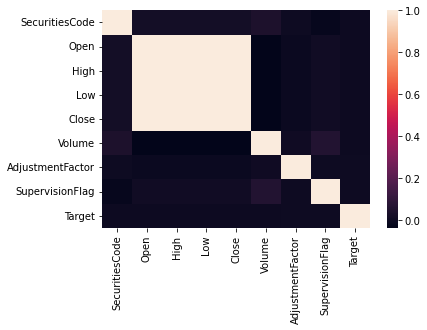

In [66]:
corr = stock_price_data.drop(columns = ['Date', 'RowId', 'ExpectedDividend']).corr()
sns.heatmap(corr)

From the diagram, we can deduce that the correlation between the Open, High, Low, Close is very high, and the correlation between one of the feature and Target is under 0.4, some features are not useful for the prediction for the correalation which is less than 0.2 or more singly.

Now, we need more information about the correaltion between Open, High, Low, Close.

we can draw a pairplot to see it.

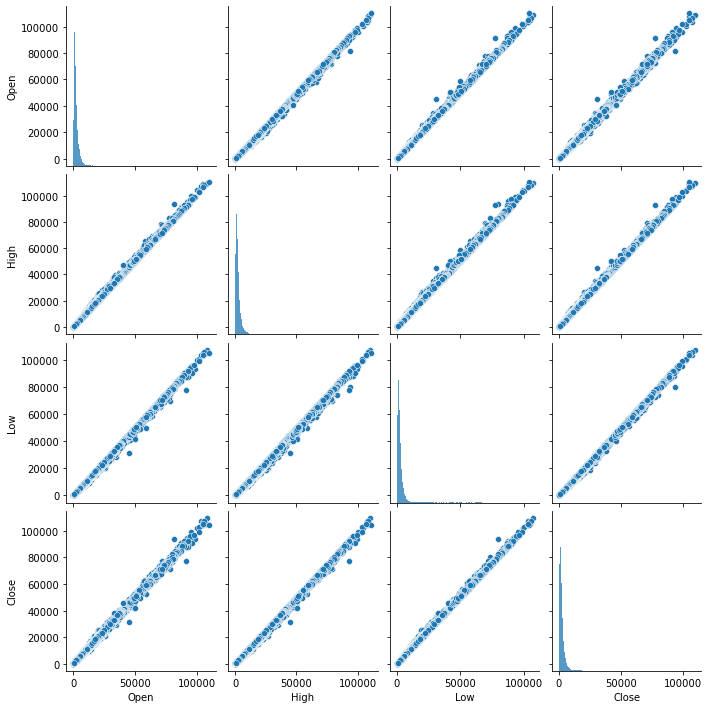

In [67]:
sns.pairplot(data=stock_price_data[['Open', 'High', 'Low', 'Close']], kind = 'scatter')

Now, we can conclude that the Open, High, Low, Close are highly correlated

In financial market, we often use data to see whether the stock price is going up or down due to the style of the market.

In [68]:
# group the data by year 
year = stock_price_data['Date'].apply(lambda x: x[:4])
stock_price_data['Year'] = year


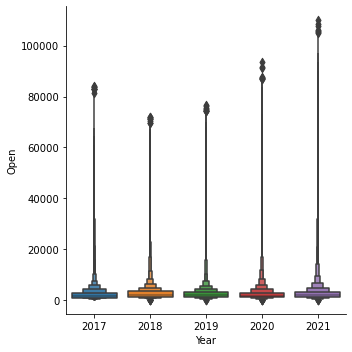

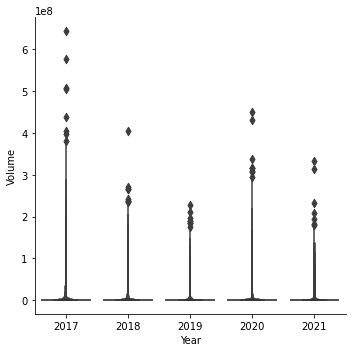

In [69]:
sns.catplot(data = stock_price_data, x='Year', y='Open', kind='boxen')
sns.catplot(data = stock_price_data, x='Year', y='Volume', kind='boxen')

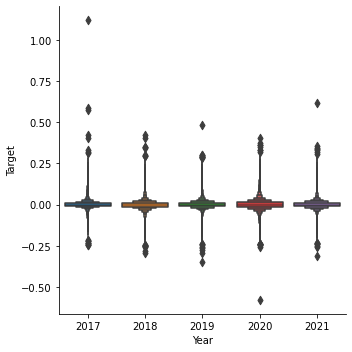

In [70]:
sns.catplot(data = stock_price_data, x='Year', y='Target', kind='boxen')

The diagram shows that there is no huge style change in the past 5 years in Japan, and some outlier values exist in it.

For Target, Open , Volumne, we can draw following diagrams

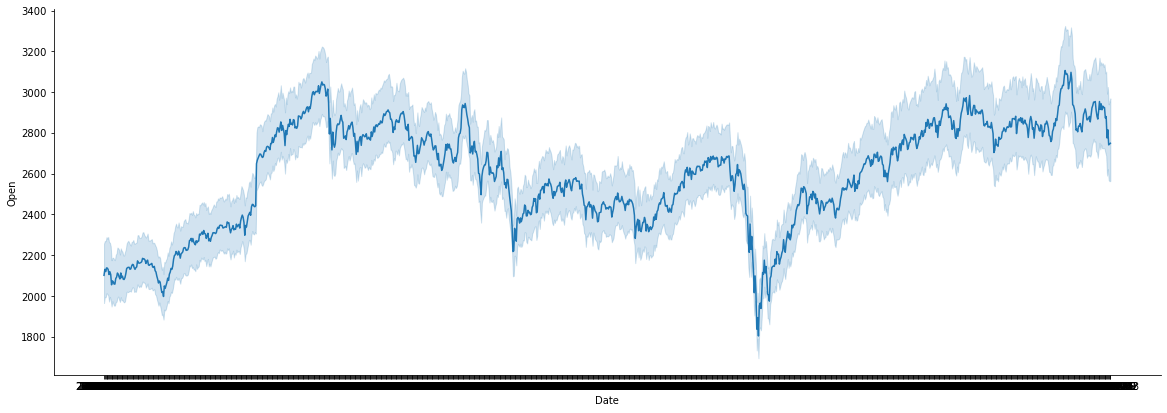

In [71]:

ax = sns.relplot(x = 'Date', y = 'Open', data = stock_price_data, kind='line')
ax.figure.set_size_inches(20,6)

Now,let's see the impact of SupervisionFlag on Open and Target. (grouped by years)

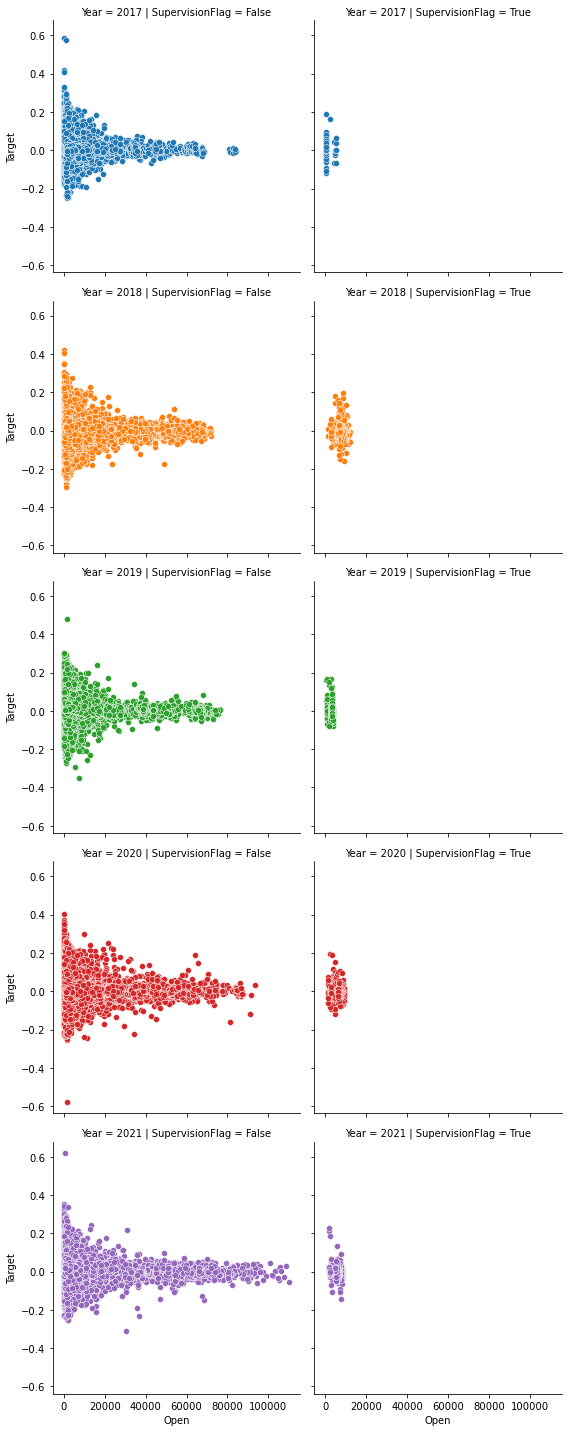

In [72]:
fig = sns.FacetGrid(stock_price_data, row='Year',col='SupervisionFlag', hue='Year', height=4)
fig.map(sns.scatterplot,'Open', 'Target')

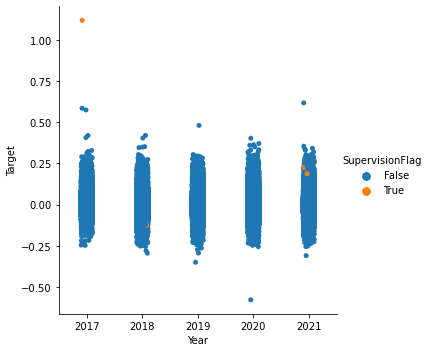

In [73]:
sns.catplot(data=stock_price_data, x='Year', y='Target', hue='SupervisionFlag')

Now we create a LGBM Baseline for stock price prediction.

In [7]:
stock_price_data['Date'] = pd.to_datetime(stock_price_data['Date']).dt.strftime('%Y%m%d').astype(int)


In [8]:
# self defined GroupTimeSeriesSplit
class GroupTimeSeriesSplit(_BaseKFold):

    def __init__(self, n_splits=5, *, max_train_size=None):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):


        n_splits = self.n_splits
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_folds = n_splits + 1
        indices = np.arange(n_samples)
        group_counts = np.unique(groups, return_counts=True)[1]
        groups = np.split(indices, np.cumsum(group_counts)[:-1])
        n_groups = _num_samples(groups)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of groups: {1}.").format(n_folds, n_groups))
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        for test_start in test_starts:
            if self.max_train_size:
                train_start = np.searchsorted(
                    np.cumsum(
                        group_counts[:test_start][::-1])[::-1] < self.max_train_size + 1, 
                        True)
                yield (np.concatenate(groups[train_start:test_start]),
                       np.concatenate(groups[test_start:test_start + test_size]))
            else:
                yield (np.concatenate(groups[:test_start]),
                       np.concatenate(groups[test_start:test_start + test_size]))

In [27]:
def lgbm_model(train_x, train_y, validation_x, valiastion_y,index):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "learning_rate" : 0.001,
    }

    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=valiastion_y)
    evals_result_lgbm = {}
    
    model_lightgbm = lgb.train(params, lg_train, valid_sets=[lg_train, lg_validation], early_stopping_rounds=100, evals_result=evals_result_lgbm, verbose_eval=100)
    
    model_lightgbm.save_model(f'model_lightgbm_{index}.txt')
    # pre_test_lightgbm = model_lightgbm.predict(test_x, num_iteration=model_lightgbm.best_iteration)
    
    
    # return pre_test_lightgbm, model_lightgbm, evals_result_lgbm
    return  model_lightgbm, evals_result_lgbm

In [10]:
train_x = stock_price_data[['Date', 'Open', 'Close', 'High', 'Low']]
groups = stock_price_data[['SecuritiesCode']]
train_y = stock_price_data[['Target']]